<h1 style="background-color:#C71585; color:white" style="font-family: Cambria" align="center">Predicting Item-Based Future Sales using LightGBM Regression</h1> 

**Dataset:**

https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

The objective of this project is to predict 3-month sales for 50 different items across 10 different stores using data from the last five years' store item sales.

# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Importing Basic Libraries and Loading Dataset</h1> 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train= pd.read_csv('train.csv', parse_dates = ['date'])
df_train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
df_test= pd.read_csv('test.csv', parse_dates = ['date'])
df_test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [4]:
df_all= pd.concat([df_train, df_test], sort= False)
df_all

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


<a id='understand'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Understanding Dataset & EDA</h1> 

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [6]:
df_all.shape

(958000, 5)

In [7]:
df_all['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

10 stores and 50 items:

In [8]:
df_all.store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [9]:
df_all.store.nunique()

10

In [10]:
df_all.item.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [11]:
df_all.item.nunique()

50

Every store has the same number of unique items:

In [12]:
df_all.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

Total number of sales in each store:

In [13]:
#Sales Data Per Store

def total_sales_per_store(df):
    sales_by_store = df.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, order=sales_by_store.sort_values('sales',ascending = False).store)
          
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    plt.xticks(fontsize=12, rotation=45)
       
    return sales_by_store

,store,sales
0,1,4315603.0
1,2,6120128.0
2,3,5435144.0
3,4,5012639.0
4,5,3631016.0
5,6,3627670.0
6,7,3320009.0
7,8,5856169.0
8,9,5025976.0
9,10,5360158.0


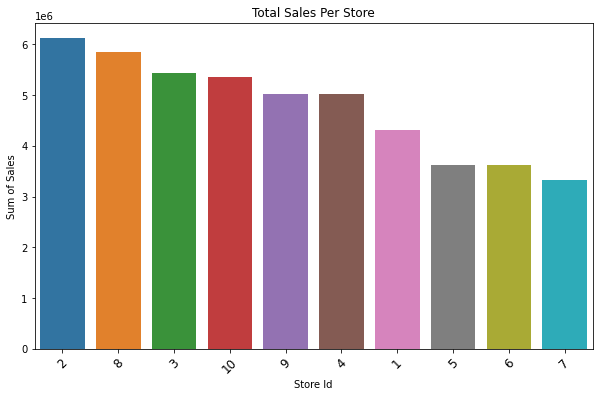

In [14]:
total_sales_per_store(df_all)

In [15]:
#Sales Data Per Item

def total_sales_per_item(df):
    sales_by_store = df.groupby('item')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(20,8))
    sns.barplot(sales_by_store.item, sales_by_store.sales, order=sales_by_store.sort_values('sales', ascending = False).item)
    
    ax.set(xlabel = "Item Id", ylabel = "Sum of Sales", title = "Total Sales Per Item")
    plt.xticks(fontsize=12, rotation=90)
    
    return

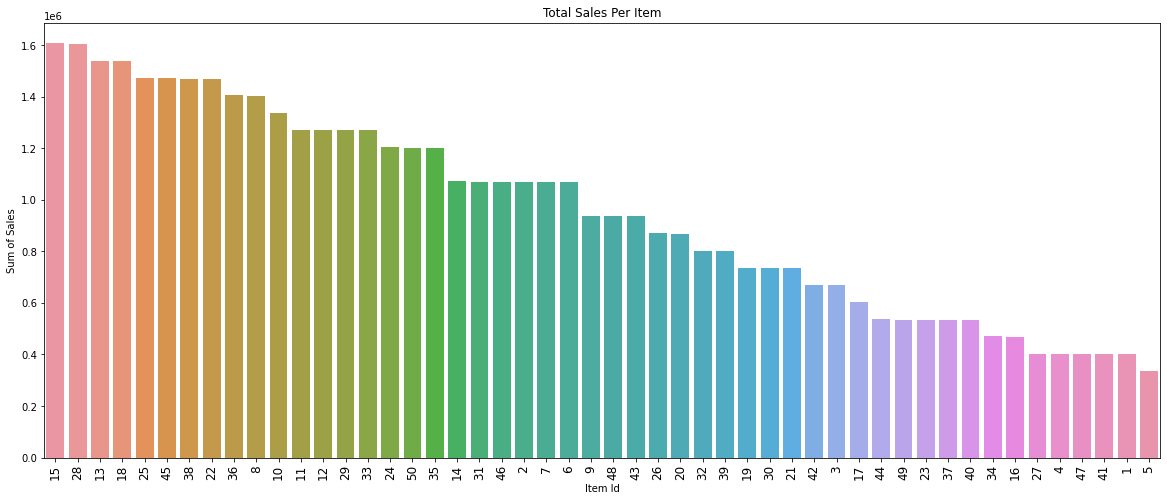

In [16]:
total_sales_per_item(df_all)

In [18]:
item_sales_per_store = df_all.groupby(['store', 'item'])['sales'].sum()
item_sales_per_store

store  item
1      1        36468.0
       2        97050.0
       3        60638.0
       4        36440.0
       5        30335.0
                 ...   
10     46      120601.0
       47       45204.0
       48      105570.0
       49       60317.0
       50      135192.0
Name: sales, Length: 500, dtype: float64

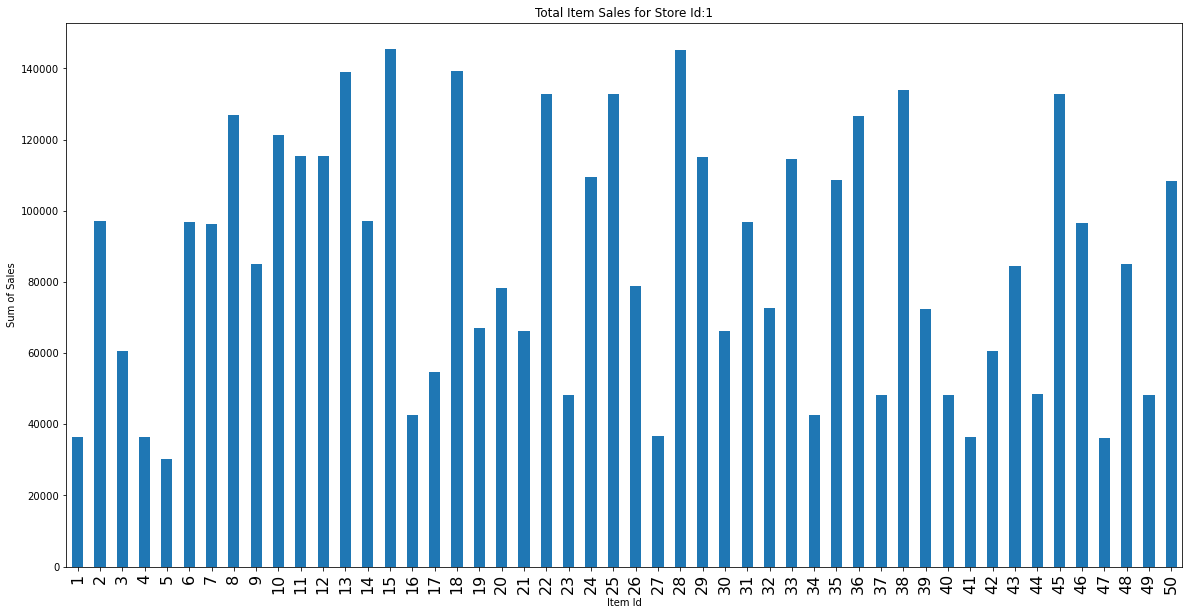

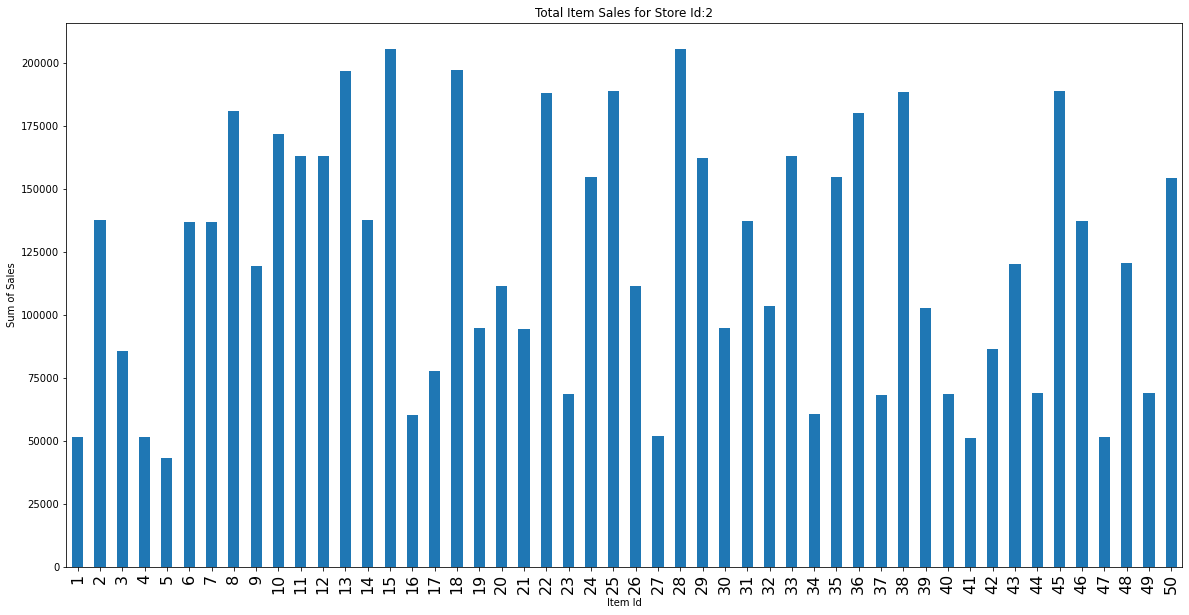

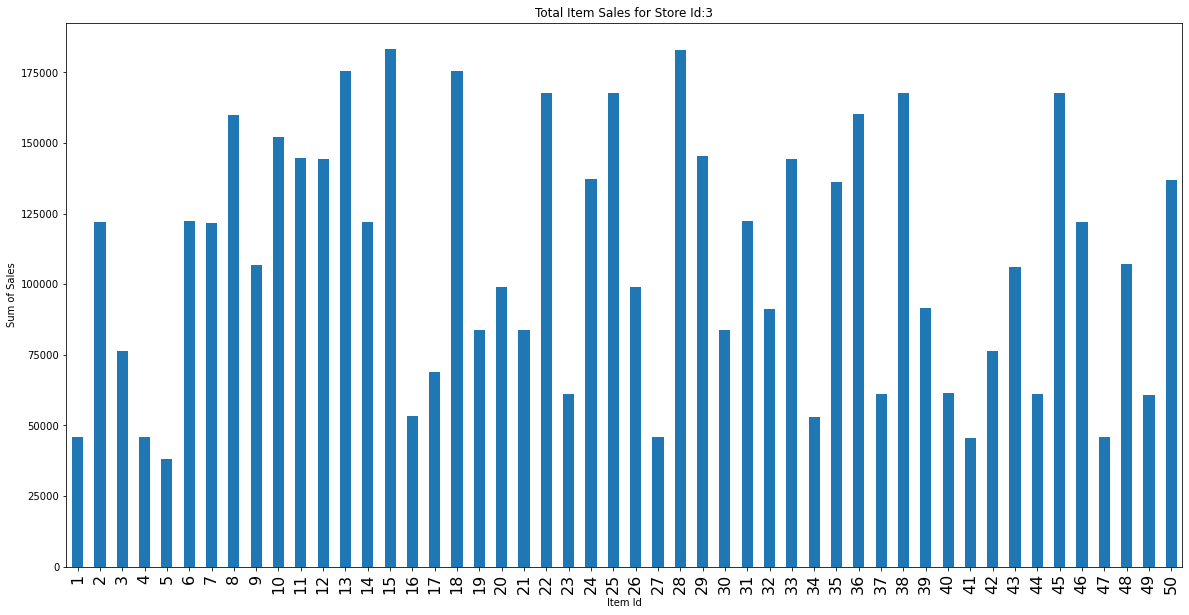

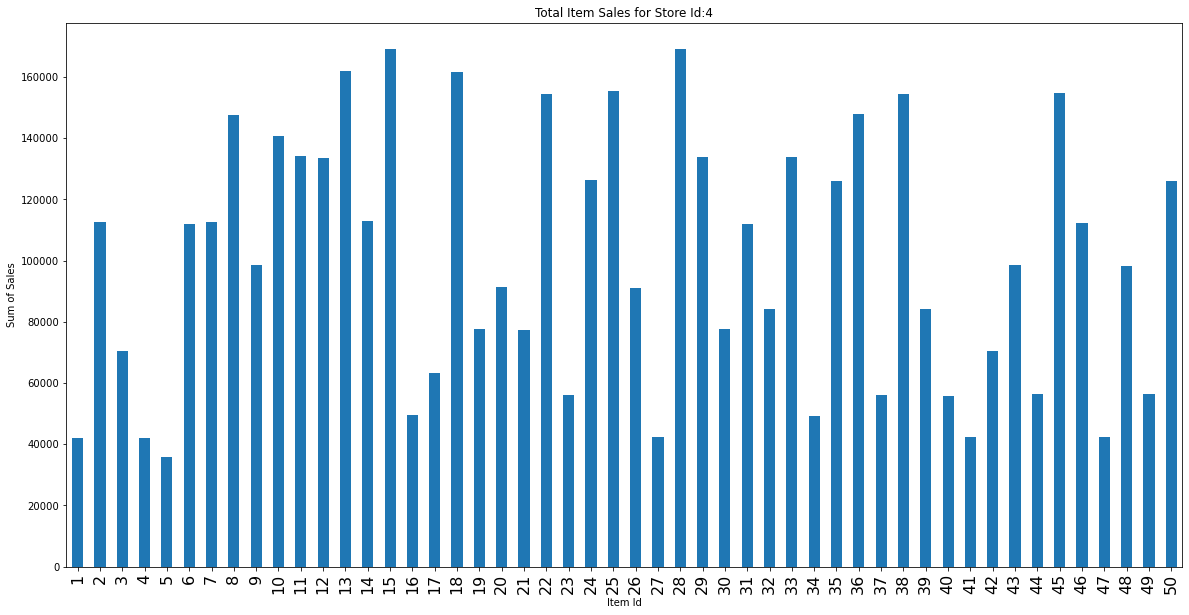

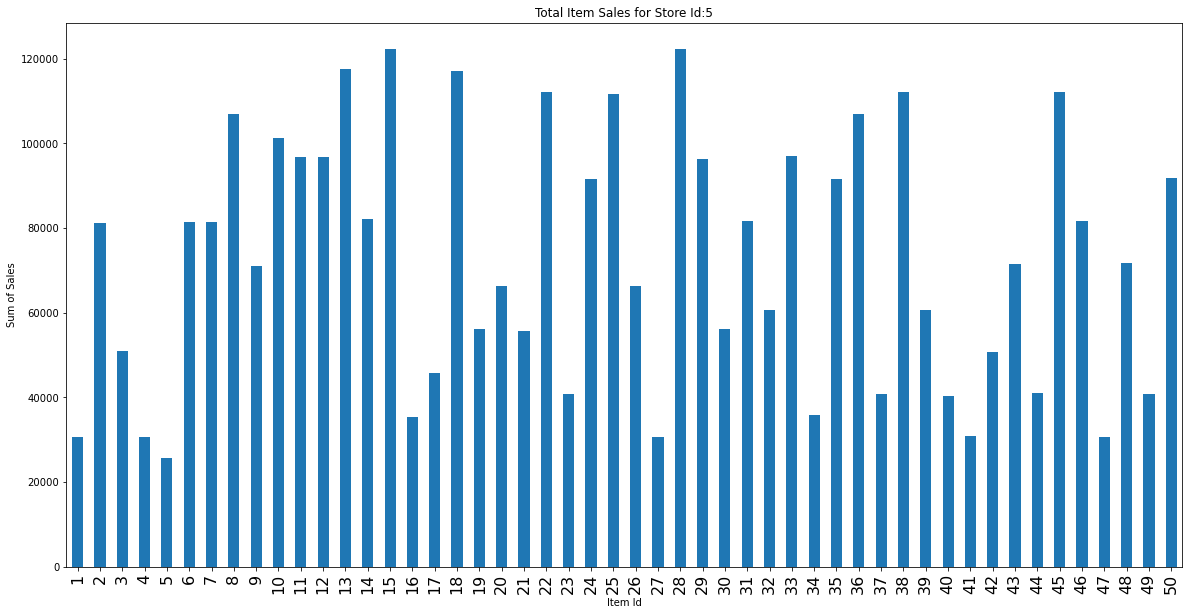

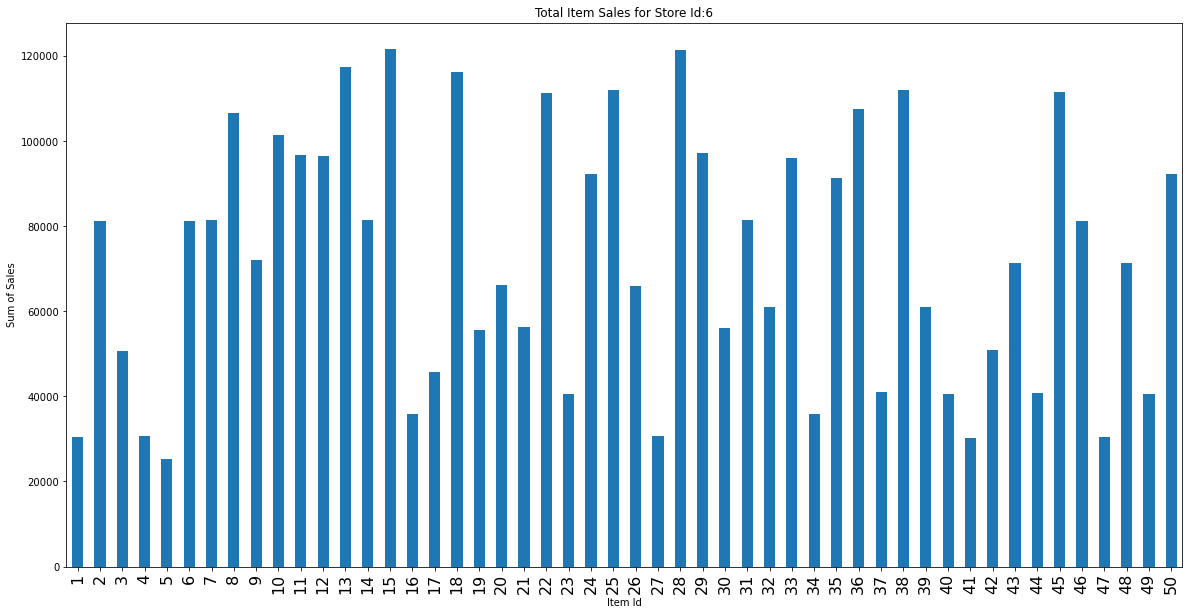

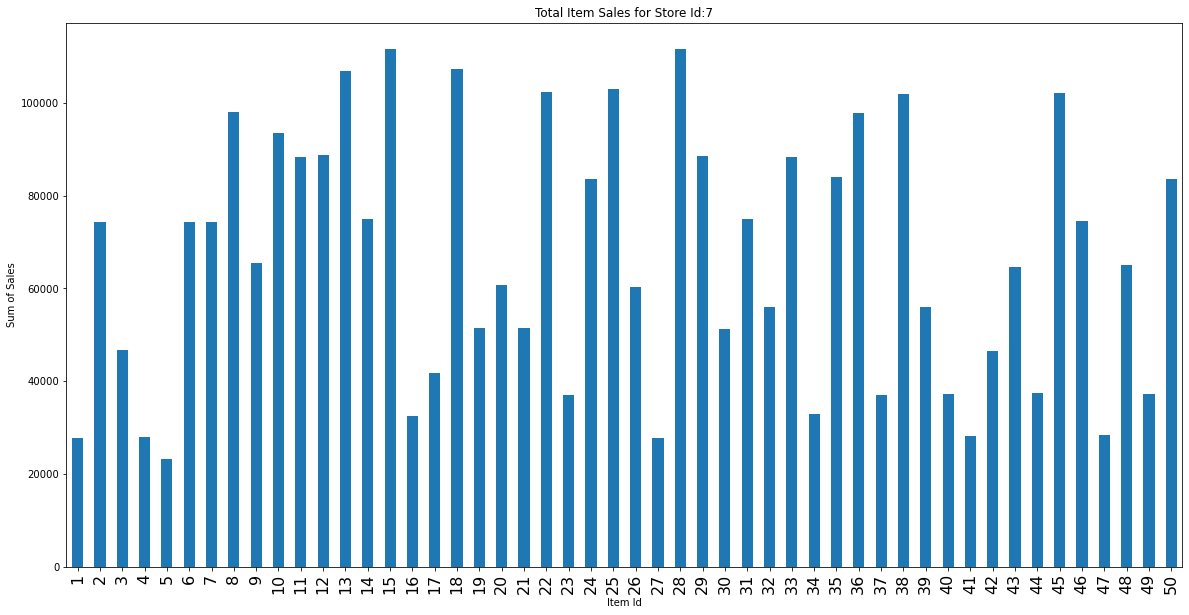

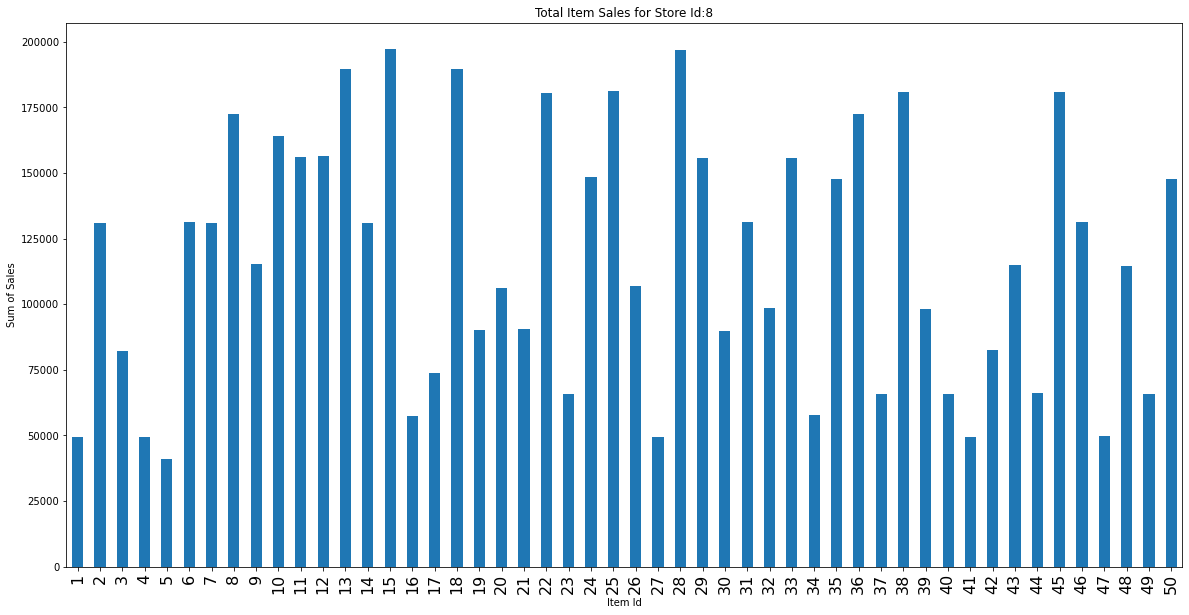

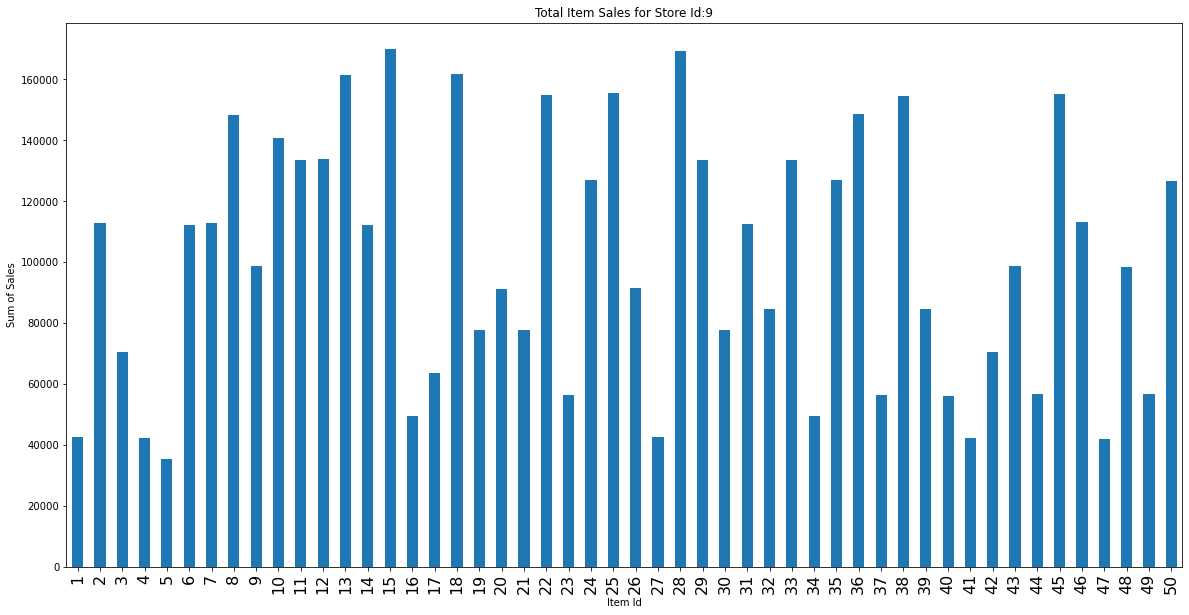

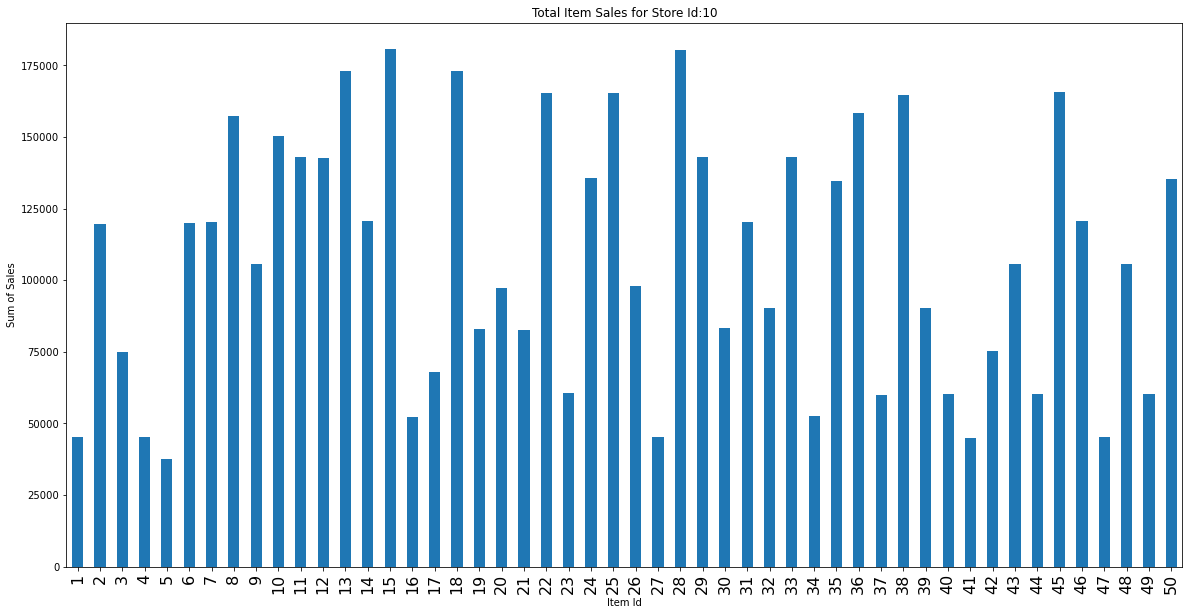

In [19]:
for i in df_all.store.unique():
    plt.figure(figsize=(20,10))
    item_sales_per_store.loc[i,:].plot(kind= "bar")
    plt.xlabel("Item Id"),
    plt.ylabel("Sum of Sales")
    plt.title("Total Item Sales for Store Id:{}".format(i))
    plt.xticks(fontsize=16, rotation=90)
    plt.show();

In [20]:
#other method
item_sales_per_store_df= pd.DataFrame(df_all.groupby(['store', 'item'])['sales'].sum())
item_sales_per_store_df.reset_index(inplace=True)
item_sales_per_store_df

,store,item,sales
0,1,1,36468.0
1,1,2,97050.0
2,1,3,60638.0
3,1,4,36440.0
4,1,5,30335.0
...,...,...,...
495,10,46,120601.0
496,10,47,45204.0
497,10,48,105570.0
498,10,49,60317.0


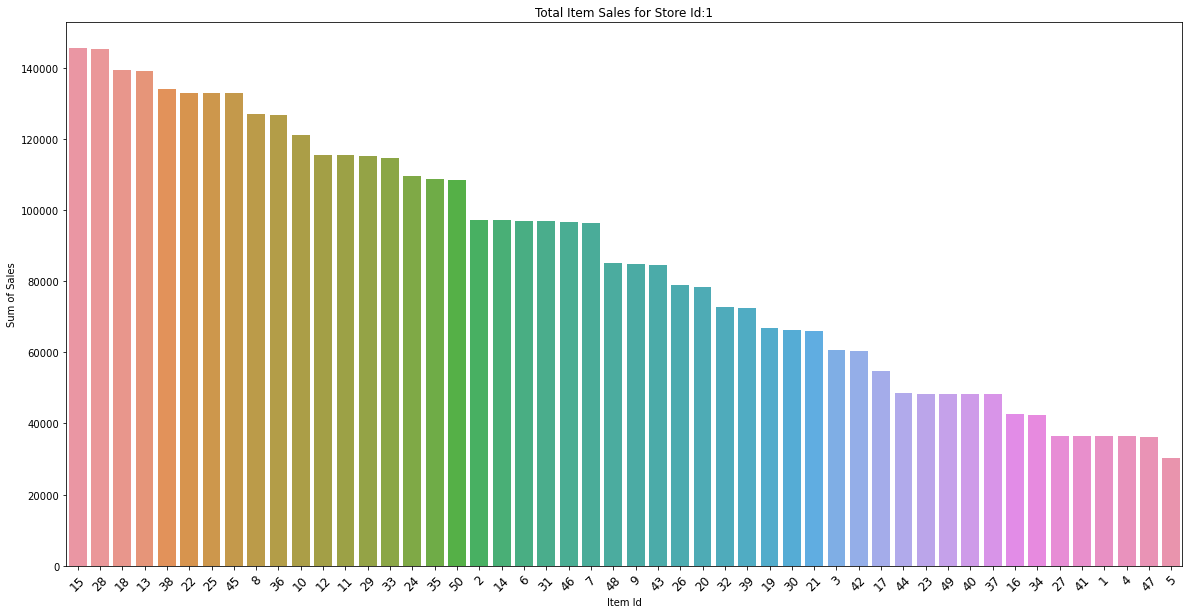

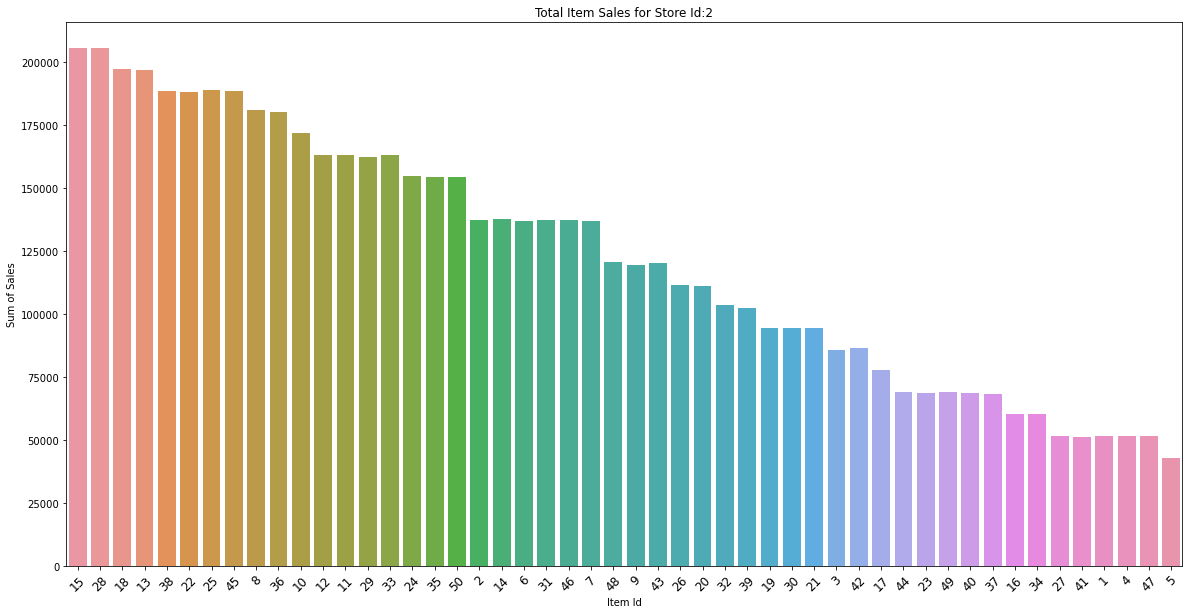

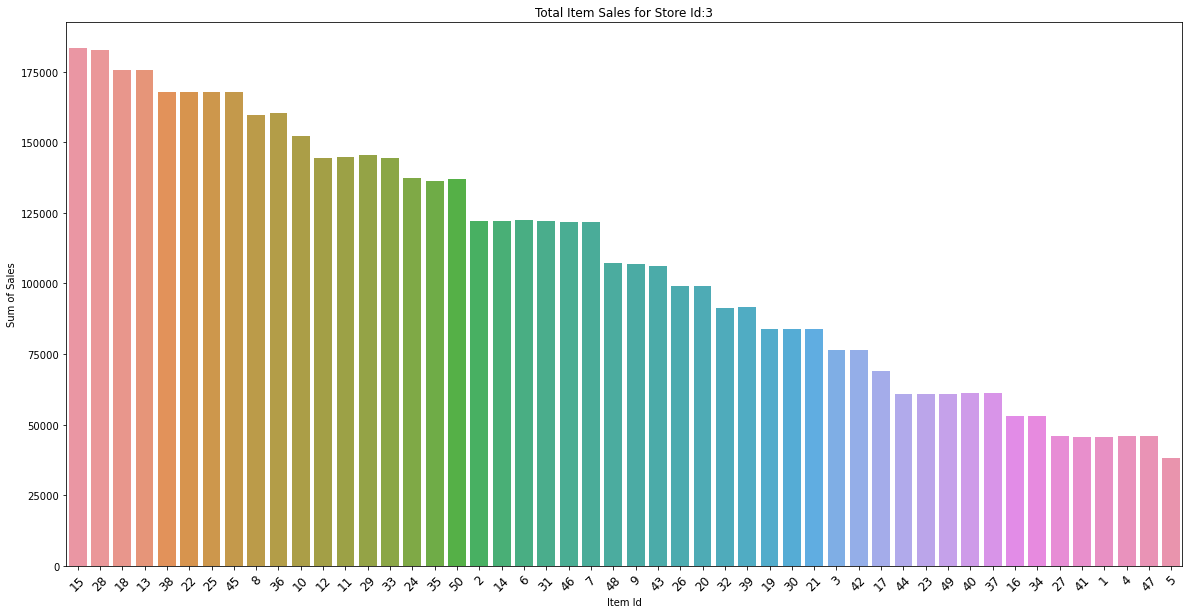

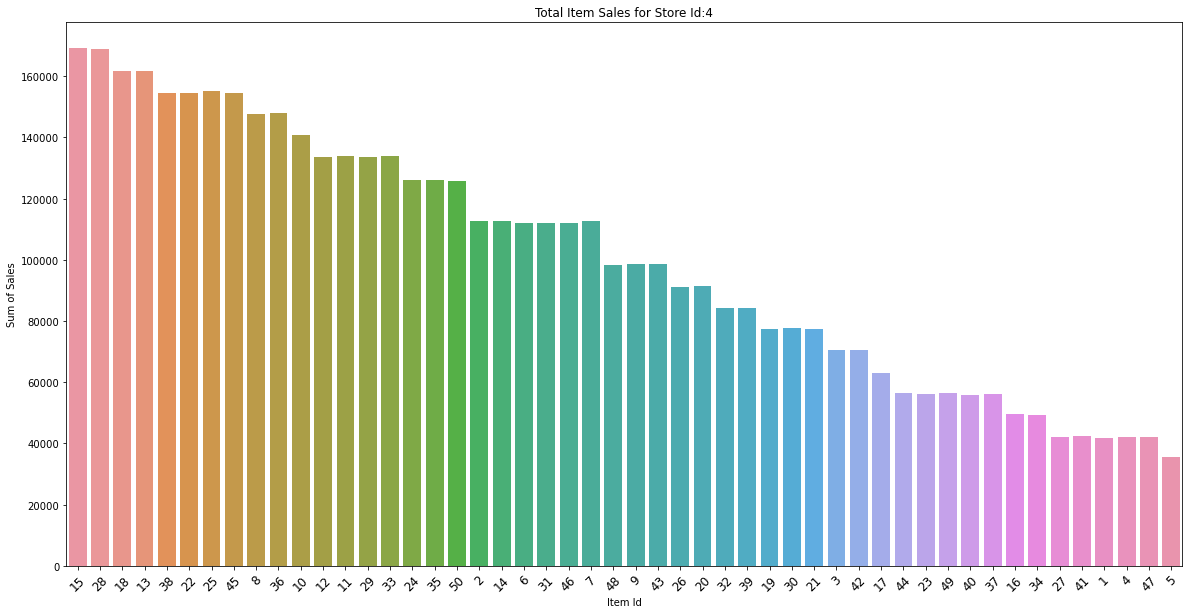

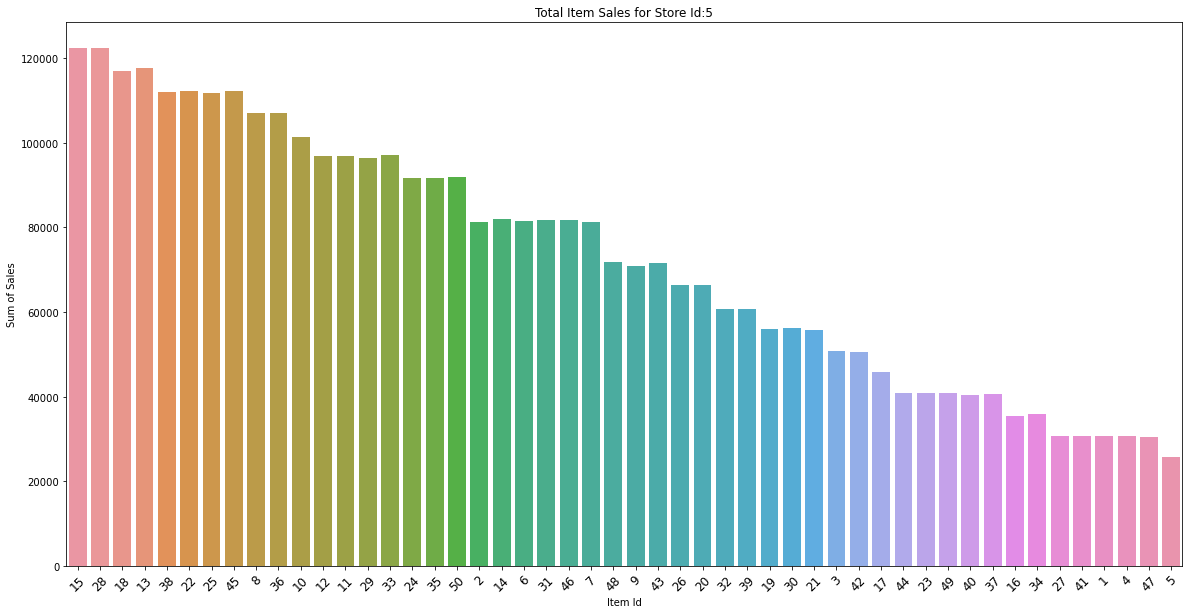

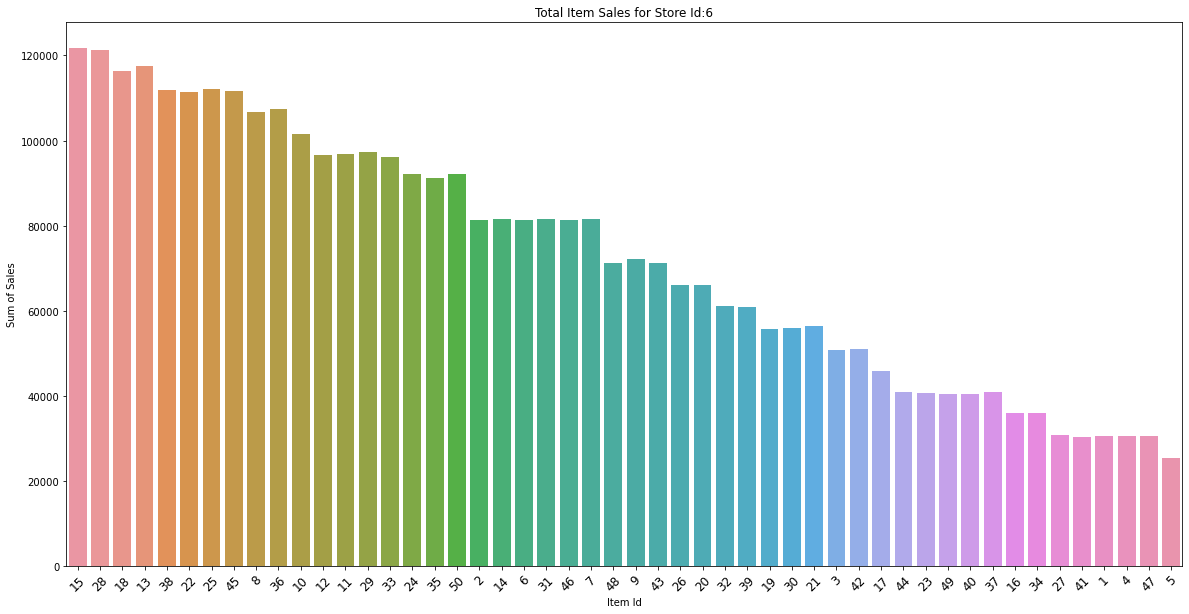

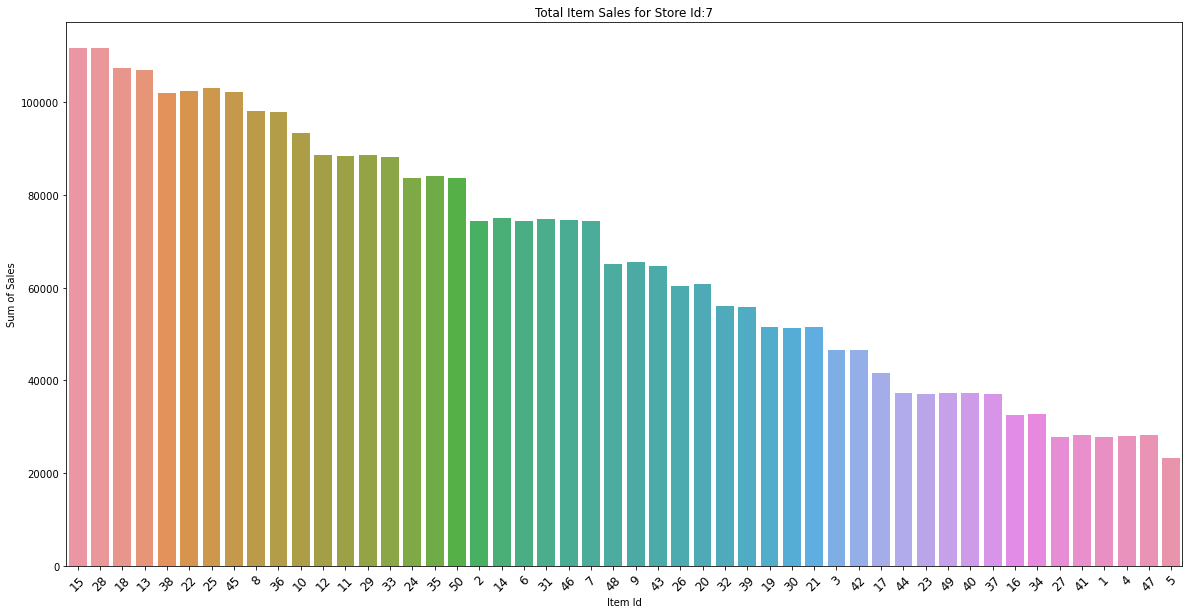

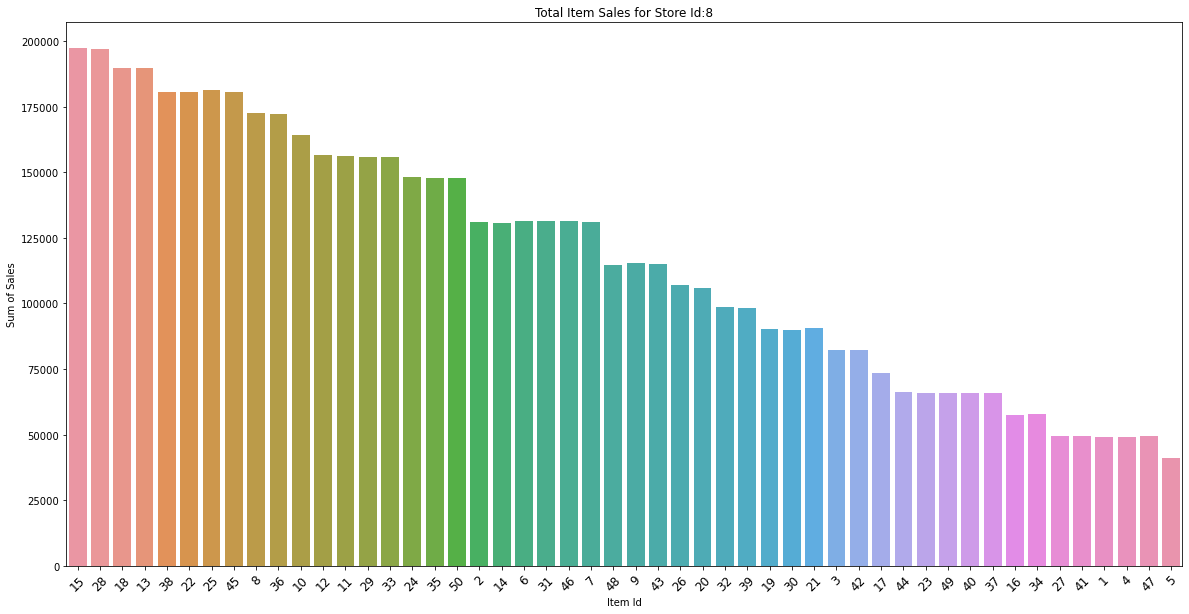

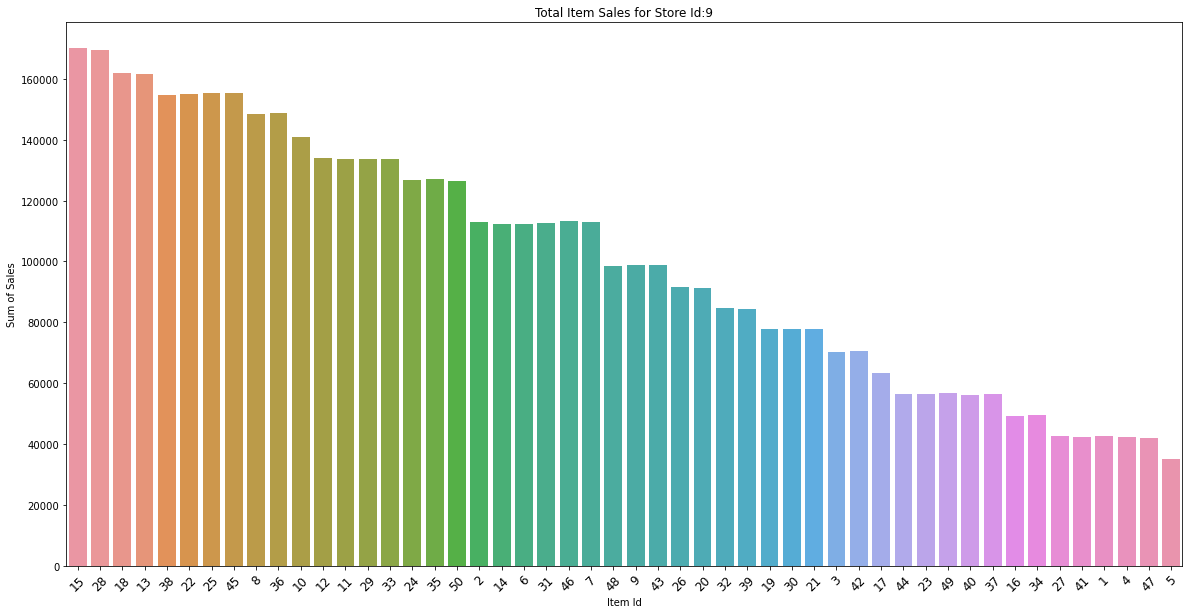

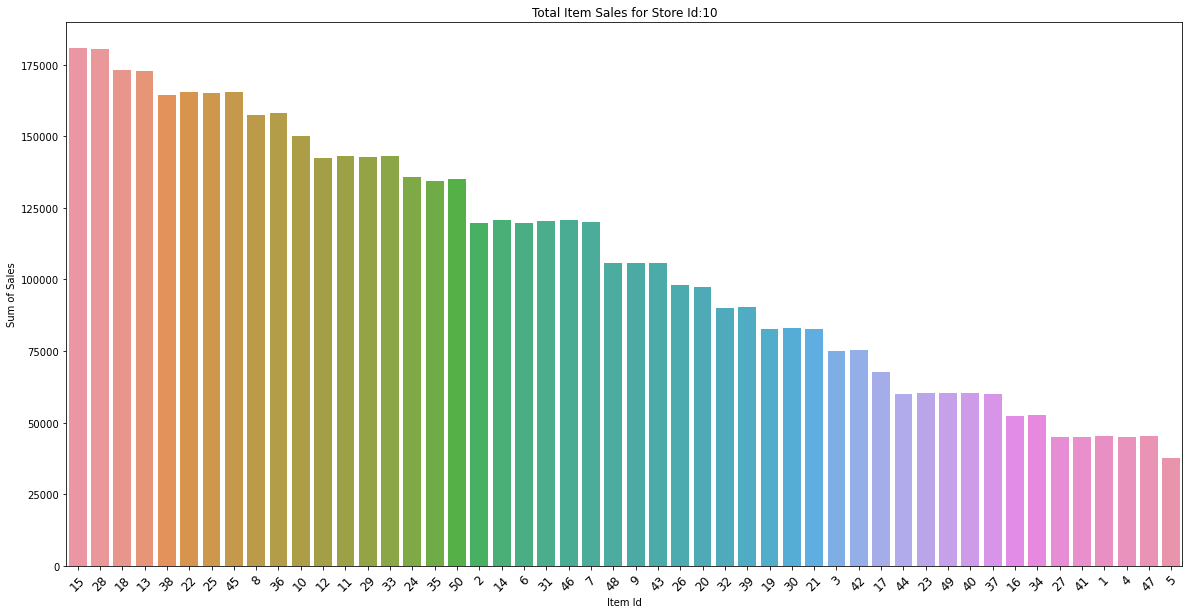

In [22]:
for i in df_all.store.unique():
    plt.figure(figsize=(20,10))
    sns.barplot(x = 'item', y = 'sales', data= item_sales_per_store_df.loc[item_sales_per_store_df.store==i], 
                order=item_sales_per_store_df.loc[item_sales_per_store_df.store==1].sort_values('sales', ascending = False).item)
    plt.xlabel("Item Id"),
    plt.ylabel("Sum of Sales")
    plt.title("Total Item Sales for Store Id:{}".format(i))
    plt.xticks(fontsize=12, rotation=45)
    plt.show();

<a id='fe'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Future Engineering</h1> 

**Date time features**

Date time features are features created from the time stamp value of each observation. Let's create them:

In [23]:
def create_date_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.weekday
    df['year'] = df.date.dt.year
    df['quarter'] = df.date.dt.quarter
    df["is_wknd"] = (df.date.dt.weekday > 4).astype(int)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df

In [24]:
df1= create_date_time_features(df_all)
df1

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end,season
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,1,0,1,0,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,1,0,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,1,0,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,1,0,0,0,1
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,1,0,0,0,1
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,1,0,0,0,1
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,0,1


some descriptive analysis:

In [25]:
df1.groupby(["store", "item", "year", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                          sum       mean median        std
store item year month                                     
1     1    2013 1       328.0  10.580645   10.0   3.085171
                2       322.0  11.500000   11.0   3.048983
                3       477.0  15.387097   15.0   3.537206
                4       522.0  17.400000   18.0   4.295948
                5       531.0  17.129032   16.0   5.327551
...                       ...        ...    ...        ...
10    50   2017 11     2574.0  85.800000   81.5  14.653233
                12     1987.0  64.096774   66.0  10.428662
           2018 1         0.0        NaN    NaN        NaN
                2         0.0        NaN    NaN        NaN
                3         0.0        NaN    NaN        NaN

[31500 rows x 4 columns]

In [26]:
df1.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [27]:
df1.groupby(["store", "item", "year"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                     sum       mean median        std
store item year                                      
1     1    2013   6025.0  16.506849   16.0   5.568069
           2014   6889.0  18.873973   19.0   5.910087
           2015   7507.0  20.567123   20.0   6.859982
           2016   7950.0  21.721311   22.0   6.691965
           2017   8097.0  22.183562   22.0   6.953278
...                  ...        ...    ...        ...
10    50   2014  25927.0  71.032877   70.0  17.430364
           2015  27081.0  74.194521   74.0  19.141405
           2016  29452.0  80.469945   82.0  18.974328
           2017  30260.0  82.904110   81.0  20.644136
           2018      0.0        NaN    NaN        NaN

[3000 rows x 4 columns]

**Lag features and window features**

Catching the trend, seasonality, and level is our primary objective.

Since this span of time is three months long, we have added it in multiples of three months, such as three months plus one week, three months plus two weeks, six months, etc.

In [28]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return df

In [29]:
df1= lag_features(df1, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df1.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Rolling Mean Features**

The rolling method is used to derive the moving average feature. The window argument also expresses how many steps to go. Average of past 2-3-5 values etc.

In [30]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return df

We will get information about 1 and 1.5 years ago:

In [31]:
df1= roll_mean_features(df1, [365, 546])

df1.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Exponentially Weighted Mean Features**

Now, we will create features with exponential moving average values corresponding to different alpha values.

In [32]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [33]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 182, 273, 364, 546, 728]


df1= ewm_features(df1, alphas, lags)

df1.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_273,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df1.shape

(958000, 73)

The number of features has increased to 73.

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   id                           45000 non-null   float64       
 5   month                        958000 non-null  int64         
 6   day_of_month                 958000 non-null  int64         
 7   day_of_year                  958000 non-null  int64         
 8   week_of_year                 958000 non-null  int64         
 9   day_of_week                  958000 non-null  int64         
 10  year                         958000 non-null  int64         
 11  quarter                    

# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">One-Hot-Encoding</h1>

In [37]:
df2 = pd.get_dummies(df1, columns=['store', 'item', 'month', 'day_of_week', "quarter", "year", "is_wknd", "is_month_start", "is_month_end", "season"])
df2.shape

(958000, 162)

# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Sales Data Logarithmic Transformation</h1>

Logarithmic transformation is a convenient means of transforming a skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively

In [38]:
df2['sales']= np.log1p(df2["sales"].values)
df2.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,...,is_wknd_0,is_wknd_1,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,1,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,NaN,NaN,NaN,NaN,...,1,0,1,0,1,0,1,0,0,0
2,2013-01-03,2.708050,NaN,3,3,1,NaN,NaN,NaN,NaN,...,1,0,1,0,1,0,1,0,0,0
3,2013-01-04,2.639057,NaN,4,4,1,NaN,NaN,NaN,NaN,...,1,0,1,0,1,0,1,0,0,0
4,2013-01-05,2.397895,NaN,5,5,1,NaN,NaN,NaN,NaN,...,0,1,1,0,1,0,1,0,0,0


# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Splitting Data</h1>

We splitted our data into train and validation sets. As the validation set, we have selected the first 3 months’ sales of 2017.

In [39]:
df_model= df2.copy()

In [40]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [41]:
train= df_model.loc[(df_model["date"] < "2017-01-01"), :]

val= df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [42]:
train

,date,sales,id,day_of_month,day_of_year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,...,is_wknd_0,is_wknd_1,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,1,0,0,0
1,2013-01-01,2.833213,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,1,0,0,0
2,2013-01-01,3.044522,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,1,0,0,0
3,2013-01-01,3.555348,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,1,0,0,0
4,2013-01-01,2.995732,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730495,2016-12-31,4.060443,NaN,31,366,52,75.0,61.0,88.0,65.0,...,0,1,1,0,0,1,1,0,0,0
730496,2016-12-31,3.610918,NaN,31,366,52,48.0,54.0,53.0,49.0,...,0,1,1,0,0,1,1,0,0,0
730497,2016-12-31,3.367296,NaN,31,366,52,44.0,33.0,35.0,32.0,...,0,1,1,0,0,1,1,0,0,0
730498,2016-12-31,4.025352,NaN,31,366,52,59.0,75.0,73.0,58.0,...,0,1,1,0,0,1,1,0,0,0


In [43]:
val

,date,sales,id,day_of_month,day_of_year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,...,is_wknd_0,is_wknd_1,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,season_0,season_1,season_2,season_3
730500,2017-01-01,3.663562,NaN,1,1,52,49.0,59.0,43.0,50.0,...,0,1,0,1,1,0,1,0,0,0
730501,2017-01-01,4.682131,NaN,1,1,52,131.0,167.0,142.0,145.0,...,0,1,0,1,1,0,1,0,0,0
730502,2017-01-01,4.077537,NaN,1,1,52,69.0,84.0,92.0,86.0,...,0,1,0,1,1,0,1,0,0,0
730503,2017-01-01,3.295837,NaN,1,1,52,40.0,34.0,33.0,33.0,...,0,1,0,1,1,0,1,0,0,0
730504,2017-01-01,3.367296,NaN,1,1,52,38.0,37.0,55.0,42.0,...,0,1,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775495,2017-03-31,4.406719,NaN,31,90,13,55.0,62.0,64.0,58.0,...,1,0,1,0,0,1,0,1,0,0
775496,2017-03-31,3.555348,NaN,31,90,13,26.0,24.0,34.0,25.0,...,1,0,1,0,0,1,0,1,0,0
775497,2017-03-31,3.784190,NaN,31,90,13,33.0,30.0,31.0,27.0,...,1,0,1,0,0,1,0,1,0,0
775498,2017-03-31,3.988984,NaN,31,90,13,38.0,44.0,42.0,52.0,...,1,0,1,0,0,1,0,1,0,0


In [44]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [45]:
X_train = train[cols]
Y_train = train['sales']

X_val = val[cols]
Y_val = val['sales']

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((730500, 159), (730500,), (45000, 159), (45000,))

# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Building and Running LGBM Regressor</h1>

It will be used SMAPE (Symmetric mean absolute percentage error (adjusted MAPE)) metric in order to evaluate the difference between forecasts and actual values, its function:

In [46]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_pred, y_true):
    smape_val = smape(np.expm1(preds), np.expm1(y_true))
    return 'SMAPE', smape_val, False

In [47]:
import lightgbm as lgb

In [48]:
model = lgb.LGBMRegressor()

In [49]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score

In [50]:
%%time
first_model= model.fit(X_train, Y_train,
                       eval_metric= lambda y_pred, y_true: [lgbm_smape(y_pred, y_true)])


print("VALID SMAPE:", smape(np.expm1(first_model.predict(X_val)), np.expm1(Y_val)))

print("\tExplained variance:", explained_variance_score(Y_val, first_model.predict(X_val)))
print("\tMean absolute error (MAE):", mean_absolute_error(Y_val, first_model.predict(X_val)))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(Y_val, first_model.predict(X_val))))
print("\tR2 score:", r2_score(Y_val, first_model.predict(X_val)))

VALID SMAPE: 13.86334947269682
	Explained variance: 0.9002967950975174
	Mean absolute error (MAE): 0.13493677376938562
	Root Mean squared error (RMSE): 0.1774726905270502
	R2 score: 0.896141557604779
CPU times: total: 1min 30s
Wall time: 43.1 s


Metrics:

- SMAPE: 13.863
- Explained variance: 0.900
- Mean absolute error (MAE): 0.134
- Root Mean squared error (RMSE): 0.177
- R2 score: 0.896

# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Feature Importances</h1>

Top 20 features:

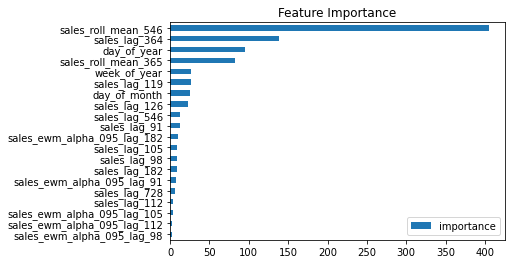

In [53]:
feature_importance= pd.DataFrame(data   = first_model.feature_importances_,
                                 index  = first_model.feature_name_,
                                 columns= ['importance'])
feature_importance.head(20).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

# <h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Predictions for the Test Data </h1> 

Let's test our model on the test dataset.

In [54]:
df_final_model= df2.copy()
train = df_final_model.loc[~df_final_model.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df_final_model.loc[df_final_model.sales.isna()]
X_test = test[cols]

In [61]:
start = time()
lgbm_params= {'learning_rate': 0.1, 
             'max_depth': 3, 
             'n_estimators': 100,
             'num_iterations': 1000,
             "verbose": 100
             }

lgbmtrain_all= lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

test_model= lgb.train(lgbm_params, lgbmtrain_all)

train_time = time() - start
#*************************************
start = time()
test_preds = test_model.predict(X_test)
predict_time = time()-start

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.883565
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.072622
[LightGBM] [Debug] init for col-wise cost 0.743785 seconds, init for row-wise cost 0.528911 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.682980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14374
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 158
[LightGBM] [Info] Start training from score 3.820443
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] 

In [62]:
test_preds

array([2.60242229, 2.7122842 , 2.75050412, ..., 4.34576688, 4.40030409,
       4.59208765])

we predicted for test set sales..

In [ ]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df.head()

Submissions...

In [63]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df.head()

,id,sales
0,0,12.496391
1,1,14.063645
2,2,14.650520
3,3,14.739488
4,4,17.173943


In [64]:
submission_df.to_csv('submission.csv', index=False)

<div style="color:white; font-size:125%; text-align:left; display:fill; border-radius:5px; background-color:#C71585; overflow:hidden">Thanks for reading. I hope you enjoy it and that it was helpful to you.<br>Please don't forget to follow me and give an upvote on</br>
👇👇👇
</div>

**<a href="https://www.kaggle.com/yaseminturker/" target="_blank" rel="noopener noreferrer">[Kaggle]</a> | 
<a href="https://github.com/yaseminturker" target="_blank" rel="noopener noreferrer">[GitHub]</a> |
<a href="https://www.linkedin.com/in/yasemin-turker/" target="_blank" rel="noopener noreferrer">[Linkedin]</a>**